In [1]:
import os
from datetime import datetime

import japanize_matplotlib
import jquantsapi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
# pandas の表示制限を調整します
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)
     


In [2]:
df_schedule = pd.read_csv(r"C:\Users\xxp2p\OneDrive\デスクトップ\ipo_csv格納庫\df_schedule_0120.csv", encoding='utf-8_sig')
df_assessments = pd.read_csv(r"C:\Users\xxp2p\OneDrive\デスクトップ\ipo_csv格納庫\df_assessments_0131.csv", encoding='utf-8_sig')
df_shareholders = pd.read_csv(r"C:\Users\xxp2p\OneDrive\デスクトップ\ipo_csv格納庫\df_shareholders_0120.csv", encoding='utf-8_sig')
df_underwriters = pd.read_csv(r"C:\Users\xxp2p\OneDrive\デスクトップ\ipo_csv格納庫\df_underwriters_0120.csv", encoding='utf-8_sig')
df_mothers_price = pd.read_csv(r"C:\Users\xxp2p\OneDrive\デスクトップ\ipo_csv格納庫\mothers_izanami.csv", encoding='Shift-JIS')
# 2020/10/01の東証のシステム障害日の行は無い

In [3]:
df_mothers_price['Date'] = pd.to_datetime(df_mothers_price['日付'], format='%Y/%m/%d')
df_mothers_price.sort_values(by='Date', ascending=True, inplace=True)
df_mothers_price = df_mothers_price.reset_index(drop=True)
df_mothers_price["oc_change"] = df_mothers_price["終値"] / df_mothers_price["始値"] - 1
df_mothers_price["cc_change"] = df_mothers_price["終値"] / df_mothers_price["始値"].shift(1) - 1
df_mothers_price["oc_change_downflag"] = [1 if x < 0 else 0 for x in df_mothers_price["oc_change"]]
df_mothers_price['oc_change'] = df_mothers_price['oc_change'].fillna(0)
df_mothers_price = df_mothers_price.dropna(subset=["始値"]).reset_index(drop=True)
df_mothers_price

,日付,始値,高値,安値,終値,出来高,前日比(率),Date,oc_change,cc_change,oc_change_downflag
0,2004/06/21,2374.68,2400.10,2374.68,2384.95,NaN,NaN,2004-06-21,0.004325,NaN,0
1,2004/06/22,2370.93,2371.30,2307.46,2307.46,NaN,-3.24%,2004-06-22,-0.026770,-0.028307,1
2,2004/06/23,2314.66,2321.72,2248.48,2253.64,NaN,-2.33%,2004-06-23,-0.026362,-0.049470,1
3,2004/06/24,2275.97,2292.70,2258.93,2292.70,NaN,+1.73%,2004-06-24,0.007351,-0.009487,0
4,2004/06/25,2304.47,2389.66,2304.47,2384.62,NaN,+4.00%,2004-06-25,0.034780,0.047738,0
...,...,...,...,...,...,...,...,...,...,...,...
4553,2023/01/26,779.33,782.87,774.77,777.28,NaN,-0.12%,2023-01-26,-0.002630,0.009769,1
4554,2023/01/27,777.15,782.39,770.61,770.96,NaN,-0.81%,2023-01-27,-0.007965,-0.010740,1
4555,2023/01/30,773.11,780.34,772.41,773.76,NaN,+0.36%,2023-01-30,0.000841,-0.004362,0
4556,2023/01/31,771.88,776.69,768.97,775.93,NaN,+0.28%,2023-01-31,0.005247,0.003648,0


In [5]:
# リフレッシュトークンの更新　メールアドレスとパスワード漏洩注意
# https://ku-ai-trade.com/j-quants-api/

# data={"mailaddress":"登録したメアド", "password":"登録したpass"}
r_post = requests.post("https://api.jpx-jquants.com/v1/token/auth_user", data=json.dumps(data))
r_post.json()
# トークン取得
refresh_token = r_post.json()['refreshToken']
# J-Quants APIクライアントを初期化します
jqapi = jquantsapi.Client(refresh_token=refresh_token)
# 銘柄情報を取得します
df_list = jqapi.get_list()

In [6]:
# 欠損値の確認
df_mothers_price[df_mothers_price[["cc_change"]].isnull().any(axis=1)]

,日付,始値,高値,安値,終値,出来高,前日比(率),Date,oc_change,cc_change,oc_change_downflag
0,2004/06/21,2374.68,2400.1,2374.68,2384.95,NaN,NaN,2004-06-21,0.004325,NaN,0


ここで検証コードつくってみる

In [7]:
# ipo検証用のdf作成[1]

# 期末発行済株式数カラム作成用コード
df_fin_firsts = pd.DataFrame()
for i in df_assessments["code"].values:
# for i in [3277]:実験用
    df_fin_first = jqapi.get_fins_statements(code=i)
    df_fin_first["期末発行済株式数"] = df_fin_first["NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock"]
    df_fin_first["期末発行済株式数"] = pd.to_numeric(df_fin_first["期末発行済株式数"], errors='raise', downcast=None)
    df_fin_first["期末発行済株式数"] = df_fin_first["期末発行済株式数"].fillna(method='bfill')
    df_fin_firsts = pd.concat([df_fin_firsts,df_fin_first.iloc[:1,:]], axis=0)
# df_fin_firsts["期末発行済株式数"]

In [8]:
# 時短用 read_csv
# df_fin_firsts = pd.read_csv(r"C:\Users\xxp2p\OneDrive\デスクトップ\df_fin_firsts.csv", encoding='utf-8_sig')
# df_fin_firsts["LocalCode"] = df_fin_firsts["LocalCode"].astype(str)


# 時短用　確認用to_csv
# df_fin_firsts.to_csv(r"C:\Users\xxp2p\OneDrive\デスクトップ\df_fin_firsts.csv", encoding='utf-8_sig',index=False)

In [9]:
# ipo検証用のdf作成[2]

# indexのリセット 
df_fin_firsts = df_fin_firsts.reset_index(drop=True)
# mergeのためにcode列を作成し文字列型で最後の０を抜く
df_fin_firsts["code"] = df_fin_firsts["LocalCode"]
# 最後の一文字を消す
df_fin_firsts["code"] = df_fin_firsts["code"].str[:-1]
# 数値型に変更
df_fin_firsts["code"] = df_fin_firsts["code"].astype(int)
# 必要なカラムのみ残す
df_fin_firsts["期末発行済株式数_開示日"] = df_fin_firsts["DisclosedDate"]
df_fin_firsts = df_fin_firsts[[
    "code",
    "期末発行済株式数",
    "期末発行済株式数_開示日"
]]
# merge
df_ipo_inspection = df_assessments[[
    "code",
    "初値（円）",
    "想定価格（円）",
    "上場市場"
    ]]

df_ipo_inspection = pd.merge(df_ipo_inspection,df_fin_firsts, on="code", how="inner")
df_schedule_ipo = df_schedule[[
    "code",
    "上場日",
    "当選株数合計（株）"
]]

df_ipo_inspection = pd.merge(df_ipo_inspection,df_schedule_ipo, on="code", how="inner")


# 時価総額カラム作成
df_ipo_inspection["時価総額_想定価格計算"] = df_ipo_inspection["期末発行済株式数"] * df_ipo_inspection["想定価格（円）"]
df_ipo_inspection["時価総額_初値計算"] = df_ipo_inspection["期末発行済株式数"] * df_ipo_inspection["初値（円）"]

# 公募＋売出の総額
df_ipo_inspection["公募売出総額_想定価格計算"] = df_ipo_inspection["当選株数合計（株）"] * df_ipo_inspection["想定価格（円）"]
df_ipo_inspection["公募売出総額_初値計算"] = df_ipo_inspection["当選株数合計（株）"] * df_ipo_inspection["初値（円）"]


In [10]:
# 日付でソートするための日付列をdatetime型に変換
df_ipo_inspection["上場日"] = pd.to_datetime(df_ipo_inspection["上場日"])
df_ipo_inspection = df_ipo_inspection.loc[df_ipo_inspection["上場市場"] == "マザーズ",:]

In [11]:
# 日付列でソート
df_ipo_inspection.sort_values(by='上場日', ascending=True, inplace=True)

In [12]:
# 時価総額_初値計算でソート 500億以上
df_ipo_inspection.sort_values(by='時価総額_初値計算', ascending=True, inplace=True)
df_ipo_inspection = df_ipo_inspection[df_ipo_inspection['時価総額_初値計算'] >= 5.00e+10]
df_ipo_inspection = df_ipo_inspection.reset_index(drop=True)

In [13]:
# 時価総額で抽出したipo銘柄の上場後の値動き
# ipo_price_df_list　対象銘柄上場日の5日間の値動きをdfでリストに保存（5日間）時価総額＿初値500億以上
# df_mothers_price_df_list　前後5日間ずつをリストに保存

# ipoの株価保存用リスト
df_ipo_price_list = []

df_mothers_price_list = []
mothers_oc_change_list =[]
mothers_oc_change_downflag_list = []
# cc_change用 
# df_mothers_cc_change_list = []
# mothers_cc_change_list =[]
for i in range(len(df_ipo_inspection)):
    ipo_code = df_ipo_inspection["code"][i]
    date = df_ipo_inspection["上場日"][i]
    # timestampに〇日足す（Timedelt）
    end_date = date + pd.Timedelta(days=20)
    start_date = date.strftime("%Y%m%d")
    end_date = end_date.strftime("%Y%m%d")
    # get_prices_daily_quotesのために数字に変更
    start_date = pd.to_numeric(start_date)
    end_date = pd.to_numeric(end_date)
    price = jqapi.get_prices_daily_quotes(code=ipo_code,
        from_yyyymmdd=start_date,
        to_yyyymmdd=end_date)
    # 上場日から5日間を抽出
    df_ipo_price_list.append(price[0:5])

    # マザーズ指数の値動き保存　前後の日数設定
    target_date = date
    start_index = df_mothers_price[df_mothers_price['Date'] == target_date].index[0] - 5
    end_index = df_mothers_price[df_mothers_price['Date'] == target_date].index[0] + 5
    # リストに追加
    df_mothers_price_list.append(df_mothers_price.iloc[start_index:end_index])
    mothers_oc_change_list.append(df_mothers_price.iloc[start_index:end_index].oc_change.values)
    mothers_oc_change_downflag_list.append(df_mothers_price.iloc[start_index:end_index].oc_change_downflag.values)
    # cc_change用 
    # df_mothers_cc_change_list.append(df_mothers_price.iloc[start_index:end_index].cc_change)
    # mothers_cc_change_list.append(df_mothers_price.iloc[start_index:end_index].cc_change.values)



下落確率検証

In [14]:
# マザーズ指数　全期間　ocの下落率
df_mothers_price.oc_change_downflag.mean()

0.49056603773584906

In [15]:
# マザーズipo上場前後の指数ocの下落率（上場日－5日～5日目）
np.mean(mothers_oc_change_downflag_list,axis=0)

array([0.57352941, 0.47058824, 0.42647059, 0.44117647, 0.61764706,
       0.48529412, 0.45588235, 0.36764706, 0.58823529, 0.52941176])

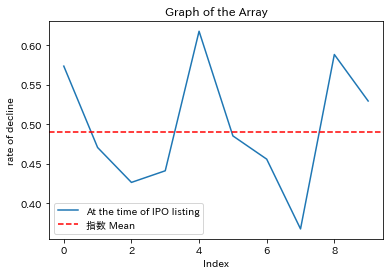

In [16]:
# 可視化
mean = df_mothers_price.oc_change_downflag.mean()
x = [i for i in range(len(np.mean(mothers_oc_change_downflag_list,axis=0)))]
y = np.mean(mothers_oc_change_downflag_list,axis=0)
plt.plot(x, y, label="At the time of IPO listing")
plt.axhline(mean,color='red', linestyle='--', label="指数 Mean")
plt.xlabel("Index")
plt.ylabel("rate of decline")
plt.title("Graph of the Array")
plt.legend()
plt.show()

In [17]:
# マザーズipo　上場前　ocの下落率（-5日～-1日目まで）
np.mean(np.mean(mothers_oc_change_downflag_list,axis=0)[0:5])

0.5058823529411764

In [18]:
# マザーズipo　上場後　ocの下落率（1日～5日目まで）
np.mean(np.mean(mothers_oc_change_downflag_list,axis=0)[5:10])


0.48529411764705876

In [19]:
# マザーズipo　上場前後　ocの下落率（全日の平均）
np.mean(np.mean(mothers_oc_change_downflag_list,axis=0))

0.49558823529411755

条件（期間2011年～、ipoマザーズ上場で時価総額（初値計算）500億以上）※68銘柄

マザーズ指数(期間2004/06/21～現在）の下落率約49%のところ

・上場前5日間平均約51%

・上場後5日間平均約49%

・上場前後の10日間平均50%

・上場前日は下落率約62％と少し高いがたまたまか？


以上から下落率はあまり変わらない。

